In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

import torch as th
from torch import nn, optim
import torch.nn.functional as F

In [2]:
?nn.Conv2d

In [48]:
# Hyperparameters
batch_size = 256
lrate = 1e-4
decay = 1e-3
n_epochs = 10


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# 1. Get the data and prepare the data handling
# In order to get the normalization first load all of the training data without the normalization transform
# data = th.cat([d for d, _ in train_loader])
# data.mean([0,2,3]), data.std([0,2,3]) then gives you the mean and std per channel

import torchvision as tv
trafo = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
        ])
train_loader = th.utils.data.DataLoader(
    tv.datasets.CIFAR10("./data", train=True, download=True, transform = trafo), 
                      batch_size=batch_size, shuffle=True)
test_loader = th.utils.data.DataLoader(
    tv.datasets.CIFAR10("./data", train=False, download=True, transform = trafo),
                     batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 2. Define the model 
##
# One note on the Batchnorm: If we are using it we usually remove the bias term 
# of the layer it normalizes as it is redundant, e.g. the first layer below would
# become nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False) instead of the
# default bias=True
class VGG16_mod(nn.Module):
    def __init__(self):
        super(VGG16_mod, self).__init__()
        self.conv_part = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),     # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
        
        self.fc_part = nn.Sequential(
            nn.Linear(512, 512),
            # nn.Dropout(0.5),        # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Linear(512, 512),
            # nn.Dropout(0.5),        # Uncomment for Exercise 03 iv)
            nn.ReLU(True),
            nn.Linear(512, 10)
        )
    
        # For a different initialization uncomment the following 
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        out = self.conv_part(x).squeeze()
        out = self.fc_part(out)
        return out
    
    
net = VGG16_mod().cuda()
print(net)

VGG16_mod(
  (conv_part): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [5]:
# 3. Define the optimizer and Loss
loss_fcn = nn.CrossEntropyLoss()  # Note: This already includes the softmax
optimizer = optim.Adam(net.parameters(), lr=lrate)

def eval_acc(net, data_loader): 
    net.eval() 
    n_pred = 0
    n_corr = 0
    with th.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            target = target.cuda()
            pred = net(data)
            n_corr += pred.argmax(1).eq(target).sum().item()
            n_pred += pred.shape[0]
    return n_corr/n_pred

Loss (0/10): 416.8940734863281


Loss (1/10): 359.6415100097656


Loss (2/10): 326.79718017578125


Loss (3/10): 287.46148681640625


Loss (4/10): 262.6036376953125


Loss (5/10): 244.06224060058594


Loss (6/10): 218.06088256835938


Loss (7/10): 201.3128662109375


Loss (8/10): 182.69703674316406


Loss (9/10): 168.45205688476562



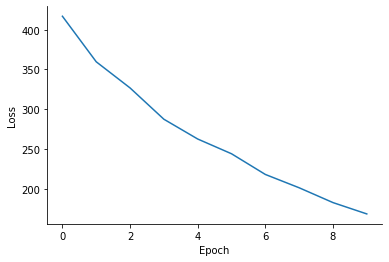

In [6]:
net.train()
tot_loss = th.zeros(n_epochs)
for t in range(n_epochs):
    for data, target in train_loader:
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad() 
        y_pred = net(data)
        loss = loss_fcn(y_pred, target)
        tot_loss[t] += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Loss ({t}/{n_epochs}): {tot_loss[t].item()}")
plt.plot(tot_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [7]:
print(f"Train Acc: {eval_acc(net, train_loader):.4f}")
print(f"Test Acc: {eval_acc(net, test_loader):.4f}")

Train Acc: 0.6962
Test Acc: 0.6484


In [27]:
with th.no_grad():
    for data, target in test_loader:
        break
    pred = F.softmax(net(data.cuda()), 1).cpu()
correct = pred.argmax(1).eq(target)

In [29]:
mean_tens = th.tensor([0.4914, 0.4822, 0.4465]).reshape(1, -1, 1, 1)
std_tens = th.tensor([0.247, 0.2435, 0.2616]).reshape(1, -1, 1, 1)
data_unnorm = data * std_tens + mean_tens

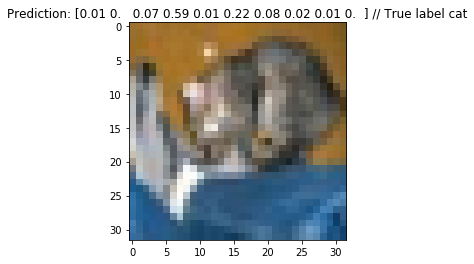

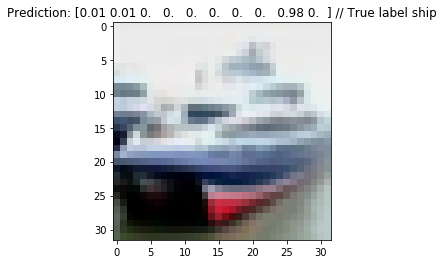

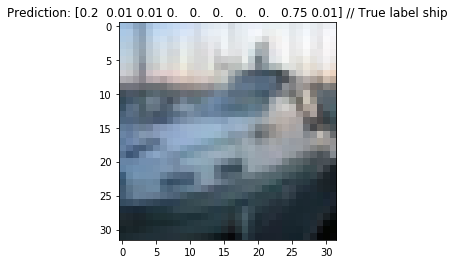

In [52]:
corr_imgs = data_unnorm[correct][:3]
probs = np.round(pred[correct][:3].data.numpy(), decimals=2)
corr_tar = target[correct]
for img, p, t in zip(corr_imgs, probs, corr_tar):
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Prediction: {p} // True label {classes[t]}")
    plt.show()

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


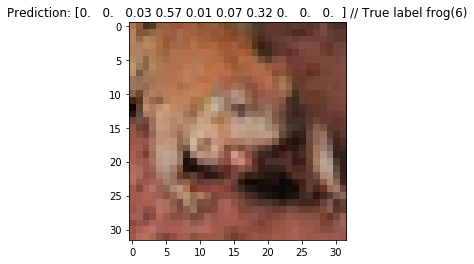

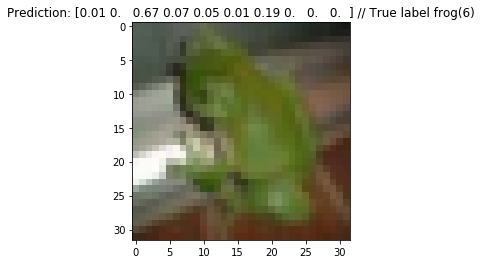

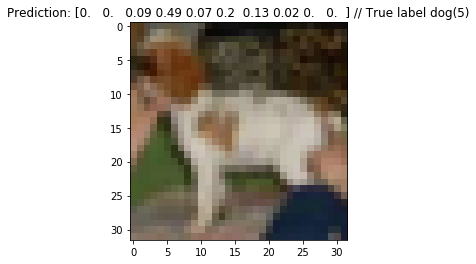

In [56]:
incorrect = np.logical_not(correct)
incorr_imgs = data_unnorm[incorrect][:3]
probs = np.round(pred[incorrect][:3].data.numpy(), decimals=2)
incorr_tar = target[incorrect]
for img, p, t in zip(incorr_imgs, probs, incorr_tar):
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Prediction: {p} // True label {classes[t]} ({t})")
    plt.show()

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']